In [1]:
from import_data_utils import *
sub = 2
cutims, voxels_ROIs_full = import_data_for_sub(sub, path)


In [ ]:
# ECoG


In [2]:
# internal imports for RDC
sys.path.insert(1, '../../')
from utils.imagenet_dataset import get_dataset
from utils.image_processing import preprocess_image_drc
from models.student_models  import student3

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# allocating memory and creating the Keras net
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[3], 'GPU')

2023-08-14 13:24:15.716683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 13:24:15.716944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 13:24:15.717152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 13:24:15.717352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 13:24:15.740023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

# Loading files & Pre-processing

## Image filtering

In [4]:
# image resizing and padding
def resize_padding(x, des_size):
    """
    This function takes the image which is already in the desired size, but minimizes it to a smaller size
    and add padding to keep the original size.  
    """
    if x.shape[0] < des_size:
        raise ValueError("Desired size must be smaller than original size!")
    neutral_color = x[0,0,0]  #pixel from the image surrounding
    padding = np.ones(x.shape) * neutral_color
    start =(x.shape[0] - des_size)//2
    end = start + des_size
    resized_im = keras.layers.Resizing(des_size, des_size, interpolation='bilinear', crop_to_aspect_ratio=False,)(x).numpy()
    padding[start:end, start:end] = resized_im
    return padding

In [5]:
#zoomin 
def zoomin_img(img, zoomsize):
    """
    This function will zoom in the image by increasing it to a bigger size and then cut and use only the middle square of it 
    to enter the network.
    
    img: an image which is already the desired size!
    zoomin = the new bigger size which we will zoom into
    """
    origin_sz = img.shape[0]
    cut = (zoomsize-origin_sz)//2
    newim = keras.layers.Resizing(zommin, zommin, interpolation='bilinear', crop_to_aspect_ratio=False,)(img).numpy()
    cutnewim = newim[cut:origin_sz+cut,cut:origin_sz+cut]
    return cutnewim

In [6]:
# Net parameters
net_size = 224
batch_size = 64
amp_list = [0,2,4,12,18,27]
# amp_list = [4]
net_lim = (len(cutims) // batch_size) * batch_size

### examples of pictures filtering

2023-08-14 13:24:15.910054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 13:24:15.910357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 13:24:15.910551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 13:24:16.187951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 13:24:16.188188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

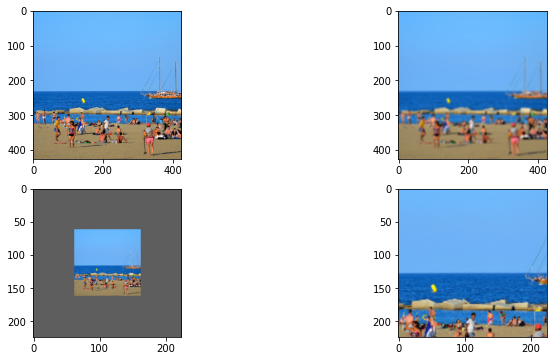

In [7]:
fig, axs = plt.subplots(2,2, figsize=(12, 6))
im1_sub1= cutims[1]
axs[0][0].imshow(im1_sub1, vmin=0, vmax=255)
#example of image cutting

#example of image blurring
im1_blur = cv2.blur(im1_sub1,(7,7))
axs[0][1].imshow(im1_blur.astype(int))

# example of the resizing the picture and adding paddings.
img = keras.layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=False,)(im1_sub1).numpy()
new_size = 100
img_res = resize_padding(img, new_size)
axs[1][0].imshow(img_res.astype(int), vmin=0, vmax=255)

#zoomin 
a = img
zommin = int(224*1.6)
origin_sz = 224
# cut = (zommin-origin_sz)//2
# a1 = keras.layers.Resizing(zommin, zommin, interpolation='bilinear', crop_to_aspect_ratio=False,)(a).numpy()
# a2 = a1[cut:zommin-cut,cut:zommin-cut]

a2 = zoomin_img(img,zommin)
axs[1][1].imshow(a2.astype(int), vmin=0, vmax=255)


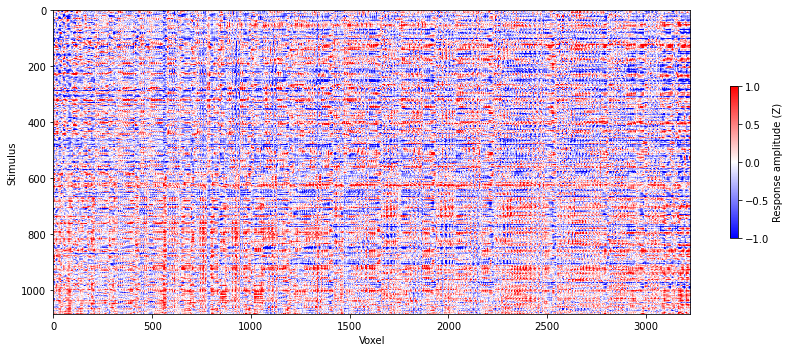

In [8]:
# Example Voxels Bold signal from voxels_vis_ROIS V1 ventral
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(voxels_ROIs_full['prf-visualrois']['V1v'],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

In [9]:
# calculate RDM for fmri data
RDM_fmri = {}
for area in voxels_ROIs_full.keys():
    RDM_fmri[area] = {}
    for roi in voxels_ROIs_full[area].keys():
        RDM_fmri[area][roi] = 1-np.corrcoef(voxels_ROIs_full[area][roi][:net_lim,:])
    print("Created RDM for: " + str(area))

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Created RDM for: floc-bodies
Created RDM for: floc-faces
Created RDM for: floc-places
Created RDM for: floc-words
Created RDM for: prf-visualrois


# Applying Alexnet

In [10]:
class pic_edit():
    """
    This class should ease applying filters and edits to the cut squered pictue before they are being proccessed by the net. 
    It aims to contain all present and future potential dynamic properties of a picture.
    """
    def __init__(self, size = 224, blur = 1):
        self.size = size
        self.blur = blur
        
    def __repr__(self):
        return f'pic({self.size, self.blur})'
    
    def __hash__(self):
        return hash((self.size, self.blur))
    
d = {pic_edit(224,1) :1}


In [11]:
# Bulilding Net

def preprocss_net(input_size, cut_ims, pic_params):
    """
    This function exectute all needed and optional steps before implementing the network over the data
    it resizes the input, and when needed it decreses and creates padding
    """ 
    input_len = len(cut_ims)
    input_net = np.zeros((input_len, input_size, input_size,3))
    for i in range(input_len):       
        input_net[i] = keras.layers.Resizing(input_size, input_size, interpolation='bilinear', crop_to_aspect_ratio=False,)(cut_ims[i]).numpy()
        if pic_params.blur > 0:
            input_net[i] = cv2.blur(input_net[i], (pic_params.blur, pic_params.blur))
        if pic_params.size < input_size:
            input_net[i] = resize_padding(input_net[i], pic_params.size)
        elif pic_params.size > input_size:
            cut = (pic_params.size-net_size)//2
            zoomin = keras.layers.Resizing(pic_params.size, pic_params.size, interpolation='bilinear', crop_to_aspect_ratio=False,)(input_net[i]).numpy()
            cutzoom = zoomin[cut:net_size+cut,cut:net_size+cut]
            if i < 1:
                plt.imshow(cutzoom.astype(int), vmin=0, vmax=255)
                plt.show()
            input_net[i] = cutzoom
    input_net = input_net[:net_lim,...]
    input_net = input_net * (1/256)
    return input_net


### DRC

In [12]:
def preprocess_for_drc_image(x,**kwargs):
    low_res_frames, _ = preprocess_image_drc(x, x.shape[-2], kwargs['res'], is_training=False,teacher_mode=False,**kwargs)
    return low_res_frames

def preprocess_for_drc_batch(x, **kwargs):
    s = np.shape(x)
    n_steps = kwargs['n_steps']
    res = kwargs['res']
    xout = np.zeros([s[0],n_steps,res,res,s[-1]])
    for ii, this_image in enumerate(x):
        xout[ii] = preprocess_for_drc_image(tf.convert_to_tensor(this_image,dtype=tf.float32),**kwargs)
    return xout

In [13]:
drc_args=dict(preprocessing='default',rggb_mode=False,
              return_position_info=False, offsets = None,
              unprocess_high_res=False,enable_random_gains=False,n_steps=5,res=57,
              central_squeeze_and_pad_factor=-1)

drc_fe_args = student_params = {'sample': 5, 'res': 57, 'activation': 'relu', 'dropout': 0.2, 'rnn_dropout': 0.0, 'num_features': 96, 'rnn_layer1': 32, 'rnn_layer2': 64, 'layer_norm': True, 'batch_norm': False, 'conv_rnn_type': 'lstm', 'block_size': 1, 'add_coordinates': 0, 'time_pool': 0, 'dense_interface': False, 'loss': 'mean_squared_error', 'upsample': 0, 'pos_det': None, 'enable_inputB': False, 'expanded_inputB': False, 'rggb_ext_type': 0, 'channels': 3, 'updwn': 1, 'kernel_size': 3, 'custom_metrics': [], 'teacher_only_mode': False, 'teacher_net_initial_weight': 0.9, 'teacher_preprsocessing': 'keras_resnet50'}

parameters = {}

parameters['pretrained_student_path'] = '/home/arivkind/pretrained_models/Alexnetmodel_drc/noname_j_t1683670714/final_weights/fe_final_weights/fe_final_weights'
parameters['pretrained_decoder_path'] = '/home/arivkind/pretrained_models/Alexnetmodel_drc/noname_j_t1683670714/final_weights/decoder_final_model/'

In [14]:
student = student3(**drc_fe_args)
student.summary()

(None, 5, 57, 57, 3)
False
(None, 57, 57, 96)
Model: "student_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 57, 57, 3)]    0         
_________________________________________________________________
convLSTM10 (ConvLSTM2D)      (None, 5, 57, 57, 32)     40448     
_________________________________________________________________
convLSTM20 (ConvLSTM2D)      (None, 5, 57, 57, 64)     221440    
_________________________________________________________________
convLSTM30 (ConvLSTM2D)      (None, 57, 57, 96)        553344    
_________________________________________________________________
layer_normalization (LayerNo (None, 57, 57, 96)        192       
Total params: 815,424
Trainable params: 815,424
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
load_status1 = student.load_weights(parameters['pretrained_student_path'])
decoder2 = keras.models.load_model(parameters['pretrained_decoder_path'])

In [16]:
net_input = keras.layers.Input(shape=(5, 57, 57, 3))
net_output = decoder2(student(net_input))
net = keras.models.Model(inputs=[net_input], outputs=net_output, name='frontend')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


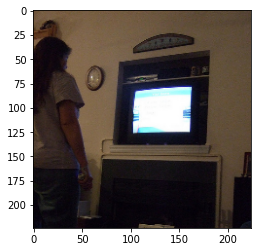

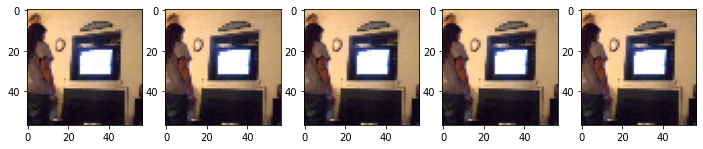

In [17]:
# Example of low resolution frames creation
img = img = keras.layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=False,)(cutims[5]).numpy()

frames_ten = preprocess_image_drc(tf.convert_to_tensor(img,dtype=tf.float32), img.shape[0], 57, is_training=False,teacher_mode=False, **drc_args)
frames_array = frames_ten[0].numpy()
frames_array.shape
plt.imshow(img.astype(int), vmin=0, vmax=255)
fig, axs = plt.subplots(1,frames_array.shape[0], figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(frames_array[i].astype(int), vmin=0, vmax=255)

In [18]:
# DRC
def preds_from_batches(layer_to_eval, data, batch_size = 64, sample_size=-1, time_mode='mean', drc_args={}):
    """
    Sasha's function for CNN application with a DRC layer. Processing each layer and saving the output
    """
    data_len = data.shape[0]
    samples_set_flag=False
       
    for batch in range(data_len//batch_size):
        start = batch * batch_size
        end = min((batch + 1)*batch_size, data_len)
        result = layer_to_eval(preprocess_for_drc_batch(data[start:end], **drc_args)) # <------
        result = result.numpy()
        if np.ndim(result) == 5:
            if time_mode == 'mean':
                result = result.mean(axis=1)
            else:
                error
        result = result.reshape([end-start,-1])
        if not samples_set_flag and sample_size > 0:
            samples = np.random.choice(result.shape[-1],sample_size)
            samples_set_flag = True
        if batch == 0:
            ll_out = np.zeros([data_len, result.shape[-1]]) if sample_size == -1 else np.zeros([data_len, sample_size])
        ll_out[start:end, :] = result if sample_size == -1 else result[:, samples]
    return ll_out

In [19]:
def corr_list_extractor(RDM_net, RDM_fmri, corr_fun=spearmanr):
    """
    This function takes all RDMs from all network layers, and all RDMS from FMRI voxels and calculate correlations.
    """
    corr_dict = {}
    for brain_area in RDM_fmri.keys():
        corr_dict[brain_area] = []
        for cnn_layer in range(len(RDM_net)):
            sz=RDM_net[cnn_layer].shape[0]
            mask = np.triu(np.ones([sz,sz],dtype=np.bool),1)
            corr, pval = corr_fun(np.nan_to_num(RDM_net[cnn_layer][mask]),RDM_fmri[brain_area][mask])
            corr_dict[brain_area].append(corr)
    print ("done correlations ")
    return corr_dict

this is the level of the execution of the network. we can run the network as many times as we wish, changing the parameters of the pictures as desired.

In [20]:
# RDM of network layers
params_list = [pic_edit(net_size,0)]

RDM_net_sz={}
for params in params_list:
    RDM_net_sz[params] = {amp:{} for amp in amp_list}
    
for ll,layer in enumerate(student.layers + decoder2.layers): # layers of 2 networks
    print(ll, layer.name)
    
    # This is where we build an appropriate feature_extractor for each layer according to the net part it belongs with
    if ll<len(student.layers): # apply student
        feature_extractor = keras.Model(
           inputs=student.inputs,
           outputs=layer.output,
        )
    else: # apply decoder on the results of student
        decoder_model = keras.Model(inputs=decoder2.inputs, outputs = layer.output)
        input0 = keras.layers.Input(shape=(5, 57, 57, 3))
        stu_output = student(input0)
        dec_output = decoder_model(stu_output)
        net = keras.models.Model(inputs=[input0], outputs=dec_output, name='frontend')
        feature_extractor = keras.Model(
        inputs=input0,
        outputs=dec_output,
        )
    
    # here we apply the net's prediction of the particular layer
    for params in params_list:
        input_net = preprocss_net(net_size, cutims, params) # <- most probably resizing to 224*224
        for amp in amp_list:
            drc_args['amp'] = amp
            if ll == 0:
                print("applying network for images with params: \r\n image size:" + str(params.size) + 
                  " || blur filter size: "+ str(params.blur) + "\r\n amp frame: " + str(amp))
            activity = preds_from_batches(feature_extractor, input_net, # <---------
                                          batch_size=64,
                                          sample_size=3000,
                                          time_mode='mean',
                                          drc_args=drc_args)
            RDM_net_sz[params][amp][ll] = 1-np.corrcoef(activity)
    del feature_extractor

0 input_1
applying network for images with params: 
 image size:224 || blur filter size: 0
 amp frame: 0
applying network for images with params: 
 image size:224 || blur filter size: 0
 amp frame: 2
applying network for images with params: 
 image size:224 || blur filter size: 0
 amp frame: 4
applying network for images with params: 
 image size:224 || blur filter size: 0
 amp frame: 12
applying network for images with params: 
 image size:224 || blur filter size: 0
 amp frame: 18
applying network for images with params: 
 image size:224 || blur filter size: 0
 amp frame: 27
1 convLSTM10


2023-08-14 13:25:07.172996: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300


2 convLSTM20
3 convLSTM30
4 layer_normalization
5 input_top
6 norm1
7 pool1
8 conv2
9 norm2
10 pool2
11 conv3
12 conv4
13 conv5
14 pool5
15 flatten
16 fc6


2023-08-14 13:40:56.138642: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17 fc7
18 fc8
19 prob


# plots

In [21]:
corr_dict = {sz : {amp : {key : corr_list_extractor(RDM_net_sz[sz][amp], RDM_fmri[key]) for key in RDM_fmri.keys()} for amp in amp_list}for sz in RDM_net_sz.keys()}

done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 


# bootstrap

In [23]:
def resample(mat,mat_):
    ii = np.random.randint(mat.shape[0],size=(mat.shape[0]))
    not_diag = np.eye(*mat.shape)<1e-5
    return mat[:,ii][ii,:],mat_[:,ii][ii,:],not_diag[:,ii][ii,:]

In [24]:
def corr_list_extractor_resampled(RDM_net,RDM_fmri,corr_fun=spearmanr):
    """
    fOR BOOTSTRAP This function takes all RDMs from all network layers, and all RDMS from FMRI voxels and calculate correlations.
    """
    corr_dict = {}
    for brain_area in RDM_fmri.keys():
        corr_dict[brain_area] = []
        for cnn_layer in range(len(RDM_net)):
            sz=RDM_net[cnn_layer].shape[0]
            mask = np.triu(np.ones([sz,sz],dtype=np.bool),1)
            RDM1, RDM2, resample_mask = resample(RDM_net[cnn_layer],RDM_fmri[brain_area])
            mask = np.logical_and(mask, resample_mask)
            corr, pval = corr_fun(np.nan_to_num(RDM1[mask]),
                                  RDM2[mask])
            corr_dict[brain_area].append(corr)
        corr_dict[brain_area] = np.array(corr_dict[brain_area])#.reshape([2,-1])
    print ("done correlations ")
    return corr_dict

In [25]:
n_resamples = 10
corr_dict_vis = {samp: {sz : {amp : corr_list_extractor_resampled(RDM_net_sz[sz][amp], RDM_fmri['prf-visualrois']) for amp in amp_list} for sz in RDM_net_sz.keys()} for samp in range(n_resamples)}

done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correla

In [26]:
n_resamples = 10
corr_dict_bodies = {samp: {sz : {amp : corr_list_extractor_resampled(RDM_net_sz[sz][amp], RDM_fmri['floc-bodies']) for amp in amp_list} for sz in RDM_net_sz.keys()} for samp in range(n_resamples)}

done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correla

In [34]:
corr_dict_vis

{0: {pic((224, 0)): {0: {'V1v': array([0.05602961, 0.05868479, 0.04565725, 0.05528615, 0.08876402,
           0.07534276, 0.09144583, 0.13730693, 0.11494536, 0.143332  ,
           0.15253725, 0.14399974, 0.1293998 , 0.10627413, 0.11855354,
           0.12460712, 0.09114221, 0.07120817, 0.04727097, 0.0349108 ]),
    'V1d': array([0.03199487, 0.03273101, 0.04463298, 0.04871987, 0.05960387,
           0.05754334, 0.06069962, 0.10432467, 0.08601743, 0.08884143,
           0.1232173 , 0.12080121, 0.10853844, 0.09294297, 0.11330682,
           0.10746805, 0.07505592, 0.05787449, 0.03857074, 0.03013728]),
    'V2v': array([0.04310687, 0.04277233, 0.04183863, 0.04423333, 0.06955227,
           0.0608968 , 0.05825844, 0.09844364, 0.09561209, 0.09406903,
           0.12837558, 0.1088676 , 0.10854366, 0.08279141, 0.11917179,
           0.09832423, 0.06971842, 0.0788739 , 0.0408428 , 0.03065674]),
    'V2d': array([0.01158491, 0.01298732, 0.00854654, 0.02758114, 0.03460188,
           0.03100083,

In [27]:
corr_dict_bodies_all= {}
for amp in amp_list:
    for area in corr_dict_bodies[0][list(corr_dict_bodies[0].keys())[0]][amp].keys():
        corr_dict_bodies_all[area] = []
        for ii in range(n_resamples):
#         print(corr_dict_vis[ii][list(corr_dict_vis[0].keys())[0]][amp])
            corr_dict_bodies_all[area].append(corr_dict_bodies[ii][list(corr_dict_bodies[0].keys())[0]][amp][area])
        corr_dict_bodies_all[area] = np.stack(corr_dict_bodies_all[area])
# corr_dict_vis_all['V1v'].shape
# corr_dict_vis_all


In [35]:
corr_dict_vis_all= {}
for amp in amp_list:
    corr_dict_vis_all[amp] = {}
    for area in corr_dict_vis[0][list(corr_dict_vis[0].keys())[0]][amp].keys():
        corr_dict_vis_all[amp][area] = []
        for ii in range(n_resamples):
#         print(corr_dict_vis[ii][list(corr_dict_vis[0].keys())[0]][amp])
            corr_dict_vis_all[amp][area].append(corr_dict_vis[ii][list(corr_dict_vis[0].keys())[0]][amp][area])
        corr_dict_vis_all[amp][area] = np.stack(corr_dict_vis_all[amp][area])


In [36]:
corr_dict_vis_all

{0: {'V1v': array([[0.05602961, 0.05868479, 0.04565725, 0.05528615, 0.08876402,
          0.07534276, 0.09144583, 0.13730693, 0.11494536, 0.143332  ,
          0.15253725, 0.14399974, 0.1293998 , 0.10627413, 0.11855354,
          0.12460712, 0.09114221, 0.07120817, 0.04727097, 0.0349108 ],
         [0.04918106, 0.05627029, 0.04904922, 0.06282479, 0.08039535,
          0.07770804, 0.08487434, 0.14028209, 0.11195586, 0.11921212,
          0.1655203 , 0.13665647, 0.13814133, 0.09659409, 0.11025927,
          0.13198165, 0.07981117, 0.0781246 , 0.04297568, 0.02934341],
         [0.05269607, 0.06498288, 0.06609532, 0.062871  , 0.07694208,
          0.08898103, 0.08476236, 0.12501265, 0.12010066, 0.10915722,
          0.15963177, 0.13272006, 0.12554603, 0.10063023, 0.12246912,
          0.13376738, 0.09332535, 0.07644481, 0.05113366, 0.03739777],
         [0.06064546, 0.06056462, 0.06378788, 0.05310574, 0.07856322,
          0.0767314 , 0.09272293, 0.13701492, 0.11376445, 0.12896368,
       

In [29]:
# ll=0
for i, key in enumerate(corr_dict_vis_all.keys()):
    x_vec = [uu for uu in range(corr_dict_vis_all[key].shape[-1]) ]
    plt.figure()
    plt.errorbar(x_vec, corr_dict_vis_all[key].mean(axis=0),
                 yerr=corr_dict_vis_all[key].std(axis=0), color = colors[i])
    plt.title(key)

NameError: name 'colors' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
for i, key in enumerate(corr_dict_vis_all.keys()):
    x_vec = [uu for uu in range(corr_dict_vis_all['V1v'].shape[-1])]
    plt.figure()
    # plt.errorbar(corr_mat70_all.mean(axis=0).T,corr_mat70_all.std(axis=0).T)
    # plt.plot(corr_mat70_all.mean(axis=0).T)
    # plt.plot(corr_mat70_all.std(axis=0).T)
    plt.plot(x_vec,
                 corr_dict_vis_all[key].mean(axis=0), color = colors[i])
    plt.fill_between(x_vec,
                 corr_dict_vis_all[key].mean(axis=0)-corr_dict_vis_all[key].std(axis=0),
                    corr_dict_vis_all[key].mean(axis=0)+corr_dict_vis_all[key].std(axis=0),alpha=0.4, color = colors[i])
    plt.title(key)

In [ ]:
for i, key in enumerate(corr_dict_bodies_all.keys()):
    x_vec = [uu for uu in range(corr_dict_bodies_all['EBA'].shape[-1])]
    plt.figure()
    # plt.errorbar(corr_mat70_all.mean(axis=0).T,corr_mat70_all.std(axis=0).T)
    # plt.plot(corr_mat70_all.mean(axis=0).T)
    # plt.plot(corr_mat70_all.std(axis=0).T)
    plt.plot(x_vec,
                 corr_dict_bodies_all[key].mean(axis=0), color = colors[i])
    plt.fill_between(x_vec,
                 corr_dict_bodies_all[key].mean(axis=0)-corr_dict_bodies_all[key].std(axis=0),
                    corr_dict_bodies_all[key].mean(axis=0)+corr_dict_bodies_all[key].std(axis=0),alpha=0.4, color = colors[i])
    plt.title(key)

# Saving the results

In [30]:
run_time = datetime.now().strftime("%Y%m%d%H%M")
run_time

path_for_save = "/home/mor/NDS_project/results_data/sub" + str(sub) + "/Alexnet/DRC/results_Alexnet_DRC_" + run_time
# Check whether the specified path exists or not
if not os.path.exists(path_for_save):
   # Create a new directory because it does not exist
   os.makedirs(path_for_save)
   print("The new directory "+ path_for_save +" is created!")

with open(path_for_save + '/corr_dict.pkl', 'wb') as handle:
    pkl.dump(corr_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print("saved corr_dict!")
    
with open(path_for_save + '/RDM_net_sz.pkl', 'wb') as handle:
    pkl.dump(RDM_net_sz, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print("saved RDM_net_sz!")
    
    


The new directory /home/mor/NDS_project/results_data/sub2Alexnet/DRC/results_Alexnet_DRC_202308141417 is created!
saved corr_dict!
saved RDM_net_sz!


In [31]:
with open(path_for_save + '/corr_dict_vis_all.pkl', 'wb') as handle:
    pkl.dump(corr_dict_vis_all, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print("saved corr_dict_vis_all!")

with open(path_for_save + '/results_explained.txt', 'a') as f:
    f.write("Subject number: " + str(sub))
    f.write(input() + '\n')
    
with open(path_for_save + '/corr_dict_bodies_all.pkl', 'wb') as handle:
    pkl.dump(corr_dict_bodies_all, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print("saved corr_dict_bodies_all!")


saved corr_dict_vis_all!
sub 2 alexnet all amps
saved corr_dict_bodies_all!


In [ ]:
path_for_save

In [ ]:
# with open(path_for_save + '/results_explained1.txt', 'a') as f:
#     f.write("Subject number: " + str(sub))
#     f.write("\nRandom weights & DRC layer\n")
#     f.write(input() + '\n')

In [ ]:
with open(path + '/voxels_ROIs.pkl', 'rb') as f:
    voxels_ROIs_s1_original = pkl.load(f)
voxels_ROIs_s1_original.keys()

In [ ]:
corr_dict_vis_all= {}
for amp in amp_list:
    corr_dict_vis_all[amp] = {}
    for area in corr_dict_vis[0][list(corr_dict_vis[0].keys())[0]][amp].keys():
        corr_dict_vis_all[amp][area] = []
        for ii in range(n_resamples):
#         print(corr_dict_vis[ii][list(corr_dict_vis[0].keys())[0]][amp])
            corr_dict_vis_all[amp][area].append(corr_dict_vis[ii][list(corr_dict_vis[0].keys())[0]][amp][area])
        corr_dict_vis_all[amp][area] = np.stack(corr_dict_vis_all[amp][area])
# corr_dict_vis_all['V1v'].shape
# corr_dict_vis_all


In [37]:
with open(path_for_save + '/corr_dict_vis_all.pkl', 'wb') as handle:
    pkl.dump(corr_dict_vis_all, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print("saved corr_dict_vis_all!")


saved corr_dict_vis_all!


In [22]:
# Import regular data
with open('/home/mor/NDS_project/results_202304200654/corr_dict.pkl', 'rb') as f:
    cor_dict_vgg = pkl.load(f)
cor_dict_vgg.keys()

with open('/home/mor/NDS_project/results_data/sub1/Alexnet/FF/Alexnet_results_202304131418/corr_dict.pkl', 'rb') as f:
    cor_dict_alex = pkl.load(f)
cor_dict_alex.keys()



FileNotFoundError: [Errno 2] No such file or directory: '/home/mor/NDS_project/results_202304200654/corr_dict.pkl'

In [ ]:
# Ploting comparing regular and DRC 
for amp in amp_list:
    for area in corr_dict[list(corr_dict.keys())[0]][amp].keys():
        fig, axs = plt.subplots(1,len(list(corr_dict.keys())) + 2, figsize=(12, 5),  sharex=True, sharey=True)
        [axs[0].plot(corr_dict[list(corr_dict.keys())[0]][amp][area][roi], '*-') for roi in list(corr_dict[list(corr_dict.keys())[0]][amp][area].keys())]
        [axs[1].plot(cor_dict_vgg[list(cor_dict_vgg.keys())[0]][area][roi], '*-') for roi in list(cor_dict_vgg[list(cor_dict_vgg.keys())[0]][area].keys())]
        [axs[2].plot(cor_dict_alex[list(cor_dict_alex.keys())[0]][area][roi], '*-') for roi in list(cor_dict_alex[list(cor_dict_alex.keys())[0]][area].keys())]

        
        axs[0].set_title("Alexnet DRC net with amp = " + str(amp))
        axs[1].set_title("Vgg16")
        axs[2].set_title("Alexnet")
        axs[0].set_ylabel("correlation")
        axs[0].set_xlabel("layer number")
        axs[1].set_xlabel("layer number")
        axs[2].set_xlabel("layer number")

        #     [ax2.plot(corr_dict[224][area][roi], '*-') for roi in corr_dict[224][area].keys()]
        fig.legend(corr_dict[list(corr_dict.keys())[0]][amp][area].keys())
        fig.suptitle("correlation for area: " + area + " || imsize: " + str(list(cor_dict_vgg.keys())[0].size), size=18)


In [ ]:
colors = [axs[0].get_lines()[i].get_color() for i in range(len(list(axs[0].get_lines())))]
colors

### Data categories

In [ ]:
# loding image metadata to find categories
cat_path = "/home/mor/annotations_trainval2017/annotations/"
fname = "instances_train2017"
f = open(cat_path + fname +'.json', "r")
data = json.loads(f.read())

imid = data['annotations'][0]['image_id']
imcat = data['annotations'][0]['category_id']
data.keys()
print([cat['name']  for cat in data['categories'] if cat['id'] == imcat])
# catname = [cat['name'] if cat['id'] == imcat for cat in data['categories']]
# data['categories'][0]
imid

im1= plt.imread(path+"/train2017/train2017/000000" + str(imid) +".jpg")
plt.imshow(im1)